In [1]:
from src.models import Exponential_Model
from src.criterion import RightCensorWrapper,RankingWrapper,RHC_Ranking_Wrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import *
from src.metrics import concordance

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter,CoxPHFitter,ExponentialFitter
from lifelines.utils import concordance_index

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy
import random
# set seeds for random!!!
torch.manual_seed(123)
random.seed(123)
np.random.seed(123)
torch.cuda.manual_seed_all(123)


C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:23: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
class ARGS(object):
    def __init__(self):
        pass

In [3]:
def loss_wrapper(loss_wrapper):
    if loss_wrapper == "rank":
        return RankingWrapper
    elif loss_wrapper == "rhc":
        return RightCensorWrapper
    elif loss_wrapper == "rhc_rank":
        return RHC_Ranking_Wrapper
    else:
        raise Exception("not valid wrapper choice")

In [4]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=150
args.lr = 5e-3
args.batch_size= 128
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=100,length=10"
args.hidden_dims = [50,50]
args.pareto = [1.0,0.0]
args.save_model = ""
args.dataset = "nwtco"
args.loss_wrapper="rhc_rank"
args.weight = 1 / args.batch_size
args.sigma = 1.0

In [5]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
# 3. Aids2
# 4. Framingham
# 5. rott2
# 6. dataDIVAT1
# 7. prostate
# 8. support2
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [6]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [7]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([3222, 14])

In [8]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))

epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("Concordance with random weights")
concordance(clf_robust,dataloader_test,epsilons)

Concordance with random weights


([1, 0.8, 0.7, 0.6, 0.5, 0.1, 0.07, 0.05, 0],
 array([0.29603413, 0.30422236, 0.31445765, 0.31651704, 0.32087012,
        0.33439797, 0.33878804, 0.33970059, 0.33894835]))

In [9]:
wrapper = loss_wrapper(args.loss_wrapper)

# # model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(wrapper(clf_robust,weight=args.weight,sigma=args.sigma),dataloader_train.dataset.tensors)
model_fragile_wrap = BoundedModule(wrapper(clf_fragile,weight=args.weight,sigma=args.sigma),dataloader_train.dataset.tensors)

In [10]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.005]
[ 1:   0]: eps=0.00000000 Loss=304177.4688 Time=0.0456
[ 1:  10]: eps=0.00000000 Loss=145473.3310 Time=0.0111
[ 1:  20]: eps=0.00000000 Loss=80142.1634 Time=0.0092
[ 1:  25]: eps=0.00000000 Loss=66956.7883 Time=0.0087
Epoch time: 0.2485, Total time: 0.2485
Evaluating...
[ 1:   6]: eps=0.00000000 Loss=321.6735 Time=0.0043
Epoch 2, learning rate [0.005]
[ 2:   0]: eps=0.00000000 Loss=287.2186 Time=0.0080
[ 2:  10]: eps=0.00000000 Loss=253.7153 Time=0.0104
[ 2:  20]: eps=0.00000000 Loss=233.9752 Time=0.0090
[ 2:  25]: eps=0.00000000 Loss=232.0259 Time=0.0092
Epoch time: 0.2678, Total time: 0.5163
Evaluating...
[ 2:   6]: eps=0.00000000 Loss=208.4452 Time=0.0057
Epoch 3, learning rate [0.005]
[ 3:   0]: eps=0.00000000 Loss=153.8224 Time=0.0099
[ 3:  10]: eps=0.00000000 Loss=229.3283 Time=0.0081
[ 3:  20]: eps=0.00000000 Loss=222.5834 Time=0.0084
[ 3:  25]: eps=0.00000000 Loss=218.8052 Time=0.0079
Epoch time: 0.2228, Total time: 0.7391
Evaluating...
[ 3:   6]:

In [11]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.005]
[ 1:   0]: eps=0.00000000 Loss=304177.4688 Time=0.0272
[ 1:  10]: eps=0.00000000 Loss=145473.3310 Time=0.0112
[ 1:  20]: eps=0.00000000 Loss=80142.1634 Time=0.0095
[ 1:  25]: eps=0.00000000 Loss=66956.7883 Time=0.0090
Epoch time: 0.2660, Total time: 0.2660
Evaluating...
[ 1:   6]: eps=0.00000000 Loss=321.6735 Time=0.0042
Epoch 2, learning rate [0.005]
[ 2:   0]: eps=0.00000000 Loss=287.2186 Time=0.0085
[ 2:  10]: eps=0.00000000 Loss=253.7153 Time=0.0068
[ 2:  20]: eps=0.00000000 Loss=233.9752 Time=0.0071
[ 2:  25]: eps=0.00000000 Loss=232.0259 Time=0.0068
Epoch time: 0.1942, Total time: 0.4602
Evaluating...
[ 2:   6]: eps=0.00000000 Loss=208.4452 Time=0.0047
Epoch 3, learning rate [0.005]
[ 3:   0]: eps=0.00000000 Loss=153.8224 Time=0.0101
[ 3:  10]: eps=0.00000000 Loss=229.3283 Time=0.0077
[ 3:  20]: eps=0.00000000 Loss=222.5834 Time=0.0072
[ 3:  25]: eps=0.00000000 Loss=218.8052 Time=0.0070
Epoch time: 0.2077, Total time: 0.6679
Evaluating...
[ 3:   6]:

In [12]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),1000)

In [13]:
clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 3222 total observations, 2765 right-censored observations>

<>:20: DeprecationWarning: invalid escape sequence '\l'
C:\Users\lpott\AppData\Local\Temp\ipykernel_23616\671205530.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])


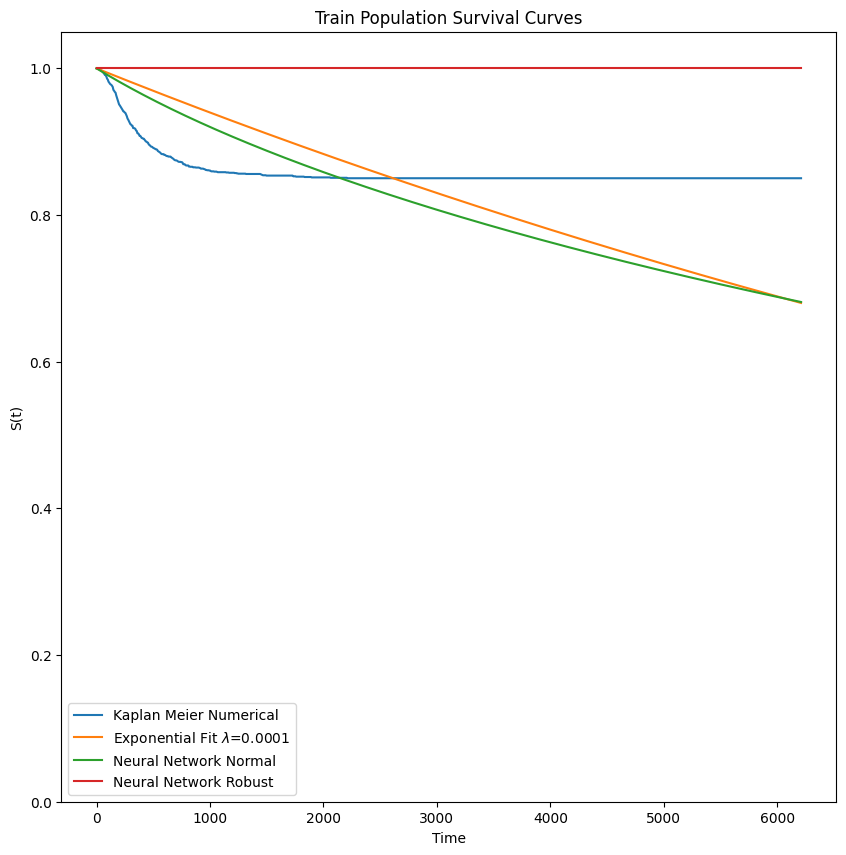

In [14]:
St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())
St_exp = clf_exp.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_exp)
plt.plot(t,St_fragile_x.mean(0))

plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.ylim([0,1.05])
plt.show()

In [15]:
print("Exponential rate parameters: ",1/clf_exp.params_.item())

Exponential rate parameters:  6.208037540003017e-05


<Axes: ylabel='Count'>

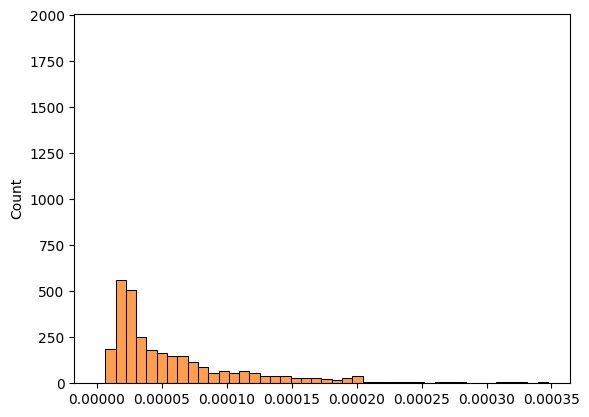

In [16]:
rates = clf_robust(X_train).detach()
rates = rates[rates < rates.quantile(0.95)]

rates_ = clf_fragile(X_train).detach()
rates_ = rates_[rates_ < rates_.quantile(0.95)]
sns.histplot(rates)
sns.histplot(rates_)

In [ ]:
visualize_individual_lambda_histograms(clf_fragile,clf_robust,dataloader_train,suptitle="train")

In [ ]:
visualize_curve_distributions(clf_fragile,clf_robust,dataloader_train,suptitle="train")

In [ ]:
visualize_curve_distributions(clf_fragile,clf_robust,dataloader_test,suptitle="test")

In [ ]:
df_train,df_test = load_dataframe(ds_name=args.dataset,drop_first=True)
from lifelines import WeibullAFTFitter
clf_cph = WeibullAFTFitter()
# clf_cph._scipy_fit_method = "SLSQP"
clf_cph.fit(df=df_train,duration_col="time",event_col="event")
kmf.plot()
clf_cph.predict_survival_function(df_train).mean(1).plot(label="Weibull AFT",figsize=(10,10))
plt.legend()
plt.ylim([0,1.05])
plt.show()
print(clf_cph.params_)

In [ ]:
print("Lifelines CPH Train CI: {:.3f}".format(clf_cph.score(df_train,scoring_method="concordance_index")))
print("Lifelines CPH Test CI: {:.3f}".format(clf_cph.score(df_test,scoring_method="concordance_index")))

# F_tr = 1-clf_exp.survival_function_at_times(times=T_train.ravel().numpy())
# exp_ci_tr = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())
# exp_ci_te = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())

# print("Lifelines EXP Train CI: {:.3f}".format(exp_ci_tr))
# print("Lifelines EXP Test CI: {:.3f}".format(exp_ci_te))

In [ ]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_train,epsilons)
plt.figure()
plt.plot(eps_,ci_)
plt.ylabel("CI")
plt.xlabel("$\epsilon$")
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_train,epsilons)
plt.plot(eps_,ci_)
plt.ylabel("CI")
plt.xlabel("$\epsilon$")
plt.legend(["Robust","Non Robust"])

In [ ]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_test,epsilons)
plt.figure()
plt.plot(eps_,ci_)
plt.ylabel("CI")
plt.xlabel("$\epsilon$")
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_test,epsilons)
plt.plot(eps_,ci_)
plt.ylabel("CI")
plt.xlabel("$\epsilon$")
plt.legend(["Robust","Non Robust"])

In [ ]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons,suptitle="train")
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons,suptitle="test")

In [ ]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="descending",test_cases=10)

visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="descending",test_cases=10)

In [ ]:
eps = 0.3
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="ascending",test_cases=10)

visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="ascending")